In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from indicator_simulation import *


/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


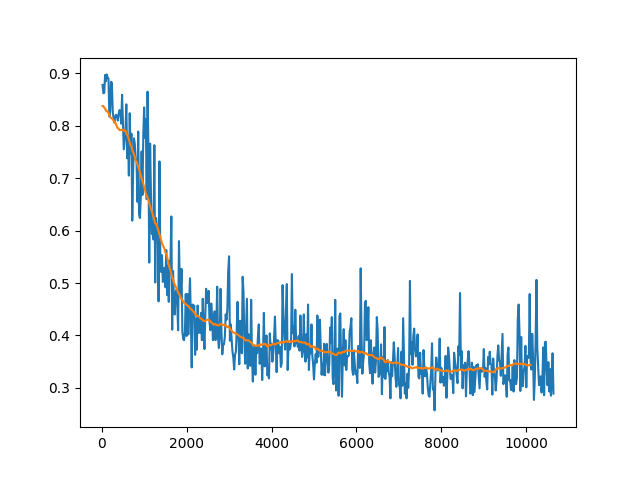

In [9]:
data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 5e-4
patience = 10
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

In [10]:
minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])
# earlyStoppingStep = 9220

9220 0.32954545454545453 505
9600 0.34330909035422585


<IPython.core.display.Javascript object>


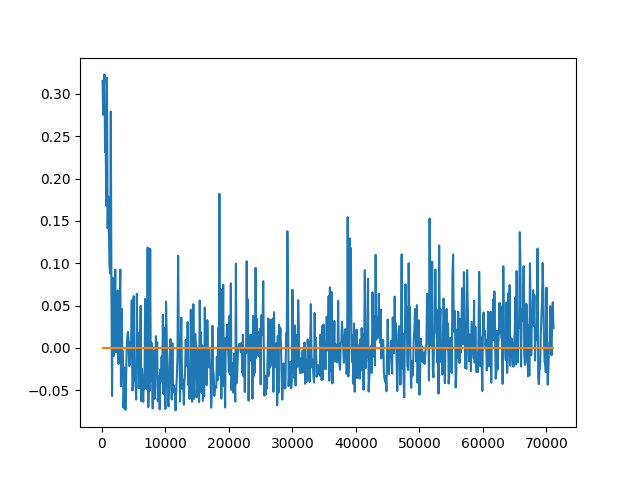

<IPython.core.display.Javascript object>


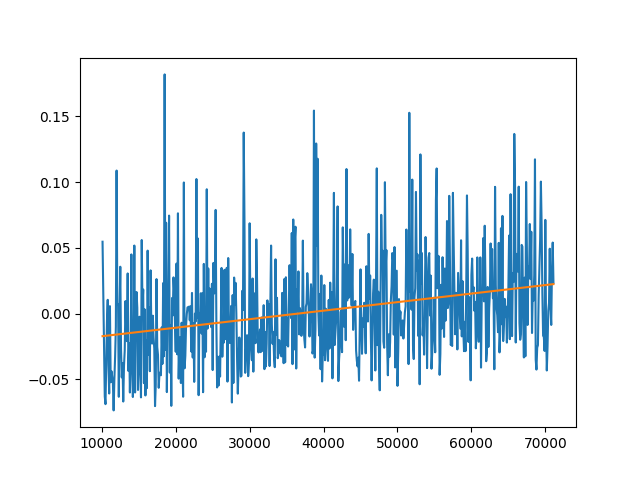

<IPython.core.display.Javascript object>


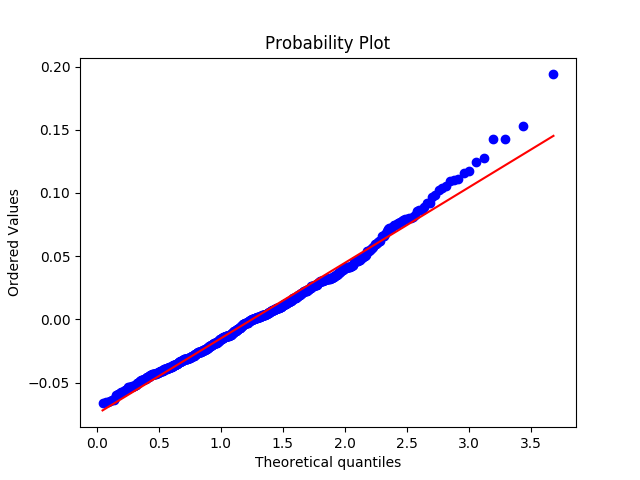

In [4]:
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
err = val_err-whole_a*np.power(steps,whole_b)
ax = plt.subplot()
ax.plot(steps, val_err-whole_a*np.power(steps,whole_b))
ax.plot(steps, np.zeros(len(steps)))

plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
ax = plt.subplot()
ax.plot(steps[100:], err[100:])
err_a, err_b = np.linalg.lstsq(np.vstack([steps[100:], np.ones(len(steps[100:]))]).T, err[100:], rcond=None)[0]
ax.plot(steps[100:], err_a*steps[100:] + err_b)

res = err[100:] - err_a*steps[100:] - err_b

plt.figure()
_ = scipy.stats.probplot(res, dist=scipy.stats.rayleigh, plot=plt)

<IPython.core.display.Javascript object>


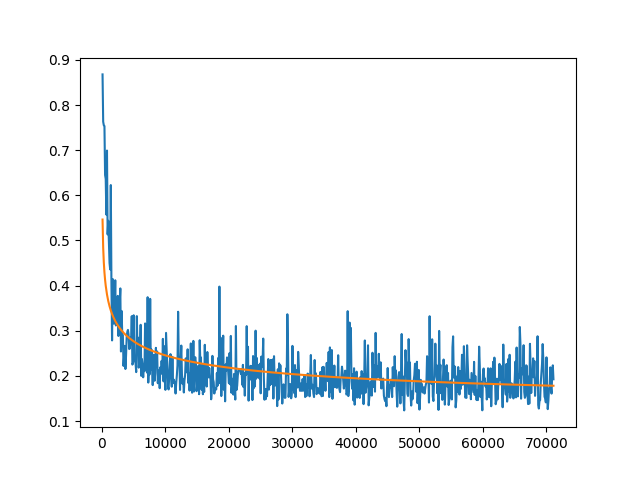

In [5]:
plt.figure()
plt.plot(steps, val_err)

fun = lambda x: np.sum(np.power(val_err-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]*(steps-x[3])),2))
bnds = ((0, None), (None, 0), (0, None),(0, None))
res = scipy.optimize.minimize(fun, (1,0,0,8000), method='TNC', bounds=bnds)

plt.plot(steps,(res.x[0]*np.power(steps, res.x[1])+res.x[2]*(steps-res.x[3])))


In [11]:
pred_win_size = 1000
left_tail_size = 0
period = 20
start_point = 5
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000
bnds = ((0, None), (None, 0), (None, None))
inits = (1,0,1)
noise_est_win_size = 300
parience = patience

# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 2e5
preds_with_patience = []
errs_with_patience = []

# patiences = range(13,14)
# for patience in patiences:
# using smoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=True,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=True,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=True,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)


1280
Predicted Stopping epoch is 3109.34. a = 1.0079391611410657, b = -0.030248529922825965, d^2=2.0574075552763657e-07
1680
Predicted Stopping epoch is 4709.18. a = 0.974982370712531, b = -0.028001273392313644, d^2=7.117585828012208e-11
2080
Predicted Stopping epoch is 15934.06. a = 2.6122023566366916, b = -0.17537143512070763, d^2=5.688913573101644e-08
2480
Predicted Stopping epoch is 17910.56. a = 3.2481926134924493, b = -0.21161279613621461, d^2=1.4909174168717884e-06
2880
Predicted Stopping epoch is 21657.26. a = 4.433423652442842, b = -0.26051852700063044, d^2=3.9444762964133684e-07
3280
Predicted Stopping epoch is 28606.1. a = 6.74317804504563, b = -0.32093335664919515, d^2=4.780811686123966e-07
3680
Predicted Stopping epoch is 26563.2. a = 6.693319105631644, b = -0.3249364833606865, d^2=3.621888457349437e-08
4080
Predicted Stopping epoch is 19171.5. a = 4.464847598675316, b = -0.2701545666556868, d^2=1.012754706115412e-08
4480
Predicted Stopping epoch is 27796.4. a = 8.11460216

/Users/stranot/qfdong/research/Early_stopping/simulate_online_regression/indicator_simulation.py:206: RuntimeWarning: divide by zero encountered in log
  fun = lambda x: np.sum(np.power(y-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]**2*(steps-steps[0])),2))


Predicted Stopping epoch is 8993.36. a = 1.3678830272901128, b = -0.0957638289001602, d^2=5.742143447276514e-11
1800
Predicted Stopping epoch is 12231.72. a = 1.6945894660386265, b = -0.1374215298504998, d^2=3.81766114613868e-15
2200
Predicted Stopping epoch is 14109.08. a = 1.9584297397731836, b = -0.1655335543349402, d^2=4.204017328215153e-11
2600
Predicted Stopping epoch is 13855.9. a = 2.1324426816237727, b = -0.18190260809598735, d^2=5.99677601878723e-13
3000
Predicted Stopping epoch is 12994.92. a = 1.8820720190378288, b = -0.1691806076814934, d^2=1.2167666733824076e-07
3400
Predicted Stopping epoch is 13549.12. a = 2.39484799991921, b = -0.20363414310160916, d^2=1.1377278658587205e-09
3800
Predicted Stopping epoch is 12971.72. a = 2.2682334383244385, b = -0.20035694581837452, d^2=3.3032441189107875e-11
4200
Predicted Stopping epoch is 13213.42. a = 2.5727481805301324, b = -0.2168663034512425, d^2=2.3774042345305637e-12
4600
Predicted Stopping epoch is 13009.52. a = 2.59103252792

<IPython.core.display.Javascript object>


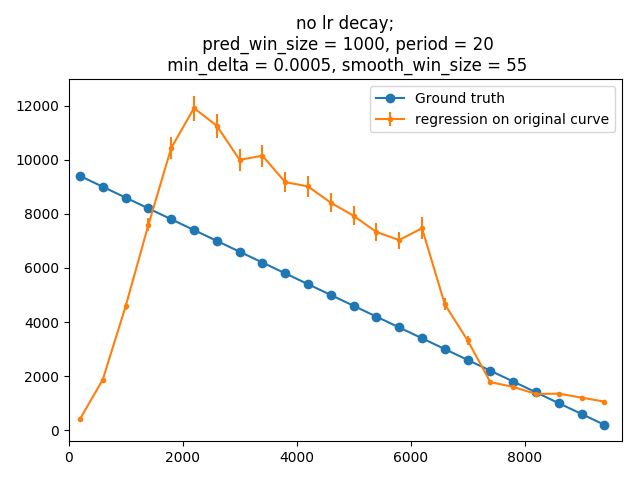

[1280 1680 2080 2480 2880 3280 3680 4080 4480 4880 5280 5680 6080 6480
 6880 7280 7680 8080 8480 8880 9280]


In [16]:
fig = plt.figure()

x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
x_smooth = (x+ (smooth_win_size-1) * num_epochs_between_eval)[:len(preds_with_patience[0])]
print(x_smooth)

plt.plot(x, earlyStoppingStep-x,'-o')

legend = ['Ground truth']
# for i, v in enumerate(patiences):
#     plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
#     legend.append('Indicator: patience = {}'.format(v))

for i in range(2): 
    if i == 0 or i == 2:
#         x_smooth = x + smooth_win_size * num_epochs_between_eval
        plt.errorbar(x_smooth, preds_with_patience[i]-x_smooth, errs_with_patience[i], fmt='.-')
#         plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
        legend.append('regression on smoothed curve')
    else:
        plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
        legend.append('regression on original curve')

plt.xlim(0,earlyStoppingStep+100)

plt.legend(legend)
plt.title('no lr decay;\n pred_win_size = {0}, period = {1}\n min_delta = {2}, smooth_win_size = {4}'.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()


plt.savefig('/Users/stranot/Desktop/resutls122118/cifar_subset_bs_128/power_linear_regression/min_delta_5e_4_patience_10_test1.png')

<IPython.core.display.Javascript object>


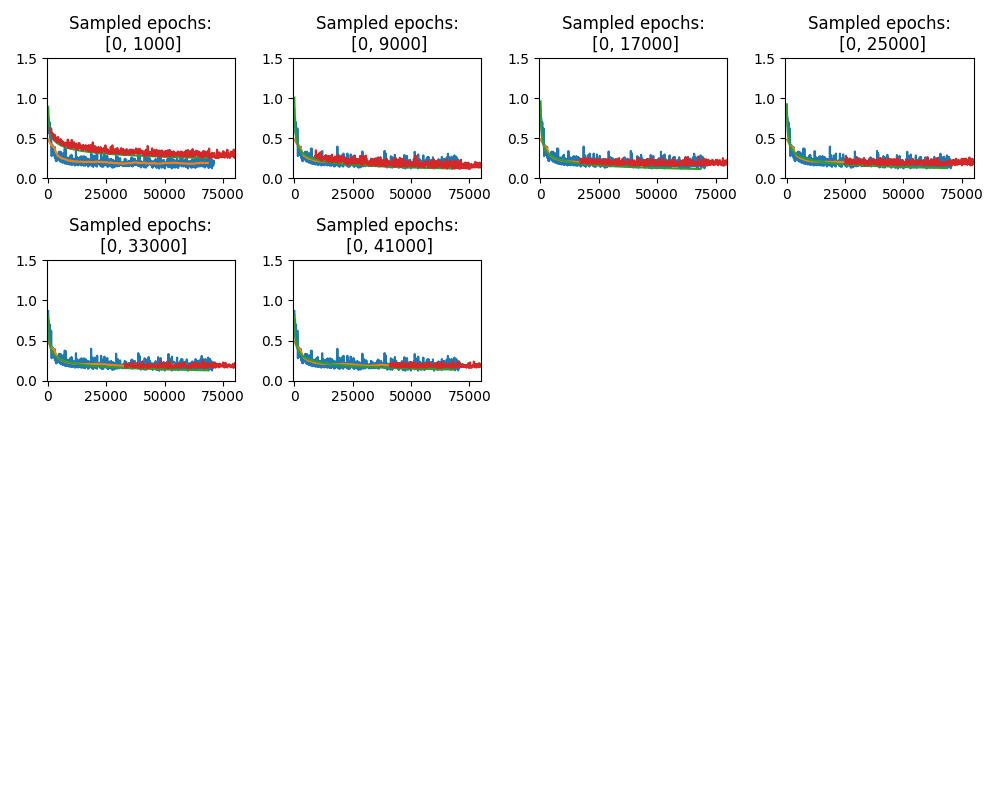

In [8]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 4
for i in range(0,len(coeffs),step_size):
#     co += 1
#     ax = plt.subplot(4,4, co)
#     ax.set_ylim(0, 1.5)
# #     ax.plot(steps, val_err)
#     ax.plot(steps[:len(whole_smoothed_val_err)], whole_smoothed_val_err)
#     x = np.arange(1,len(smoothed_samples[i])+1)*num_epochs_between_eval
# #     ax.plot(x,smoothed_samples[i])
#     ax.plot(x+shifts[i],smoothed_samples[i])
# #     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
#     e = (start_point + i*period)*num_epochs_between_eval
#     s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
#     ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
#     ax.set_xlim(-500,80000)
    
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
    ax.plot(steps, val_err)
    ax.plot(steps[:len(whole_smoothed_val_err)], whole_smoothed_val_err)
    ax.plot(steps[:len(whole_smoothed_val_err)],power_function(steps[:len(whole_smoothed_val_err)], coeffs[i][0], coeffs[i][1]))
    x = np.arange(1,len(samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x+shifts[i],samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,80000)
    
fig.tight_layout()   